In [231]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
import torch

from matplotlib import cm
from matplotlib.ticker import LinearLocator

from mpl_toolkits.mplot3d import axes3d
from sinusoidal_gradient_descent.core import complex_oscillator


## Loss visualisation for full sampling

x = -0.7072135806083679;y = -0.7072135806083679
a = tensor(1.0002); theta =tensor(-2.3562)
1.0839884281158447
x = -0.7072135806083679;y = -0.5500550270080566
a = tensor(0.8959); theta =tensor(-2.4805)
0.5015933513641357
x = -0.7072135806083679;y = -0.392896443605423
a = tensor(0.8090); theta =tensor(-2.6345)
0.5005963444709778
x = -0.7072135806083679;y = -0.2357378453016281
a = tensor(0.7455); theta =tensor(-2.8198)
0.5004563331604004
x = -0.7072135806083679;y = -0.07857927680015564
a = tensor(0.7116); theta =tensor(-3.0309)
0.5006009936332703
x = -0.7072135806083679;y = 0.07857927680015564
a = tensor(0.7116); theta =tensor(3.0309)
0.5006009936332703
x = -0.7072135806083679;y = 0.2357378453016281
a = tensor(0.7455); theta =tensor(2.8198)
0.5004563331604004
x = -0.7072135806083679;y = 0.392896443605423
a = tensor(0.8090); theta =tensor(2.6345)
0.5005963444709778
x = -0.7072135806083679;y = 0.5500550270080566
a = tensor(0.8959); theta =tensor(2.4805)
0.5015933513641357
x = -0.70721358060

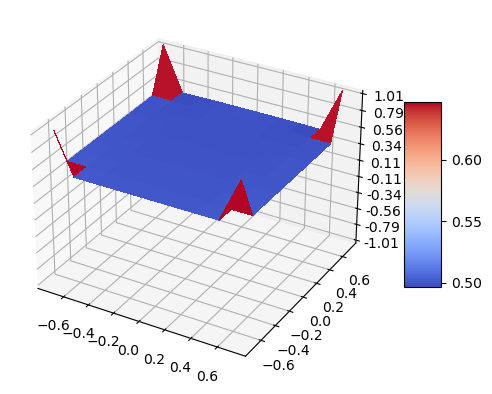

<Figure size 640x480 with 0 Axes>

In [232]:
N = 1024
n = np.arange(N)

theta0 = torch.tensor(0.2*pi)
a0 = 0.5

z0 = torch.exp(1j*theta0)

xrange = torch.linspace(-1,1,10)/1.414
yrange = torch.linspace(-1,1,10)/1.414

mse = np.zeros((xrange.shape[0],yrange.shape[0]))
target_signal = np.real(complex_oscillator(z0, N=N))

for a in range(xrange.shape[0]):
    for b in range(yrange.shape[0]):
        predicted_z = xrange[a]+1j*yrange[b]
        print('x = '+str(xrange[a].item())+';y = '+str(yrange[b].item()))
        print('a = '+str(torch.abs(predicted_z))+'; theta ='+str(torch.angle(predicted_z)))
        predicted_signal = torch.real(complex_oscillator(predicted_z, N=N))
        mse[a,b] = torch.mean((target_signal-predicted_signal)**2)
        print(mse[a,b])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


# Make data.

X, Y = np.meshgrid(xrange, yrange)
Z = mse

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.figure()
plt.show()



## Loss visualisation for random undersampling

In [233]:
M = 256

idx = np.sort(np.random.randint(0,N,(M,1)))


sampling_vector = np.zeros((N,1))
sampling_vector[idx] = 1

sampling_matrix = np.diag(sampling_vector.squeeze())

print((z0**n).shape)

rs_z0 = sampling_matrix @ z0**n

plt.figure()
plt.plot(np.real(z0**n))
plt.stem(np.real(rs_z0),'r')

plt.show()

mse = np.zeros((arange.shape[0],thetarange.shape[0]))

for i in range(arange.shape[0]):
    for j in range(thetarange.shape[0]):
        print('a = '+str(arange[i])+'; theta ='+str(thetarange[j]))
        mse[i,j] = np.mean((sampling_matrix @ (np.real(z0**n)-(arange[i]**n)*np.cos(n*thetarange[j])))**2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


# Make data.

X, Y = np.meshgrid(thetarange, arange)
Z = mse

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.figure()
plt.show()

plt.figure()
plt.plot(thetarange/pi,mse[0,:])
plt.show()

torch.Size([1024])


TypeError: unsupported operand type(s) for @: 'numpy.ndarray' and 'Tensor'